## KennTempExploration.ipynb, Kennicott Glacier temperature exploration

This code compares weather station from a bunch of sites, focused almost exclusively on the period of excellent temporal overlap between numerous sensors: melt season 2021. 

It starts by opening good corrected hourly data from Kennicott Glacier hobos (6/11/2021 17:00 to 9/8/2021 12:00) as a pickle file (homogenized_hobos.pickle) which contains a pandas table, homogenized, with fields Gates3600_degC (corrected), Kenn6100_degC (corrected), GatesAWS_degC (uncorrected), and ChineseAWS_degC (corrected). It also has GatesNPS_degC, which is direct values from the long-term NPS sensor.

I start by comparing on-glacier to off-glacier temperatures in a variety of ways, finally concluding that the best way to get on-glacier temperatures at Gates and Kenn6100 is to model them both from the long-term dataset at Gates AWS (nunatak). So I come up with a regression that predicts melt-season temps at Gates3600, and that becomes the base for a lapse-rate calculation for other sites on the glacier. 

Lapse rates are explored in various ways, mostly using Gates3600 but also trying the temp record at the bridge on Kennicott River. I end up concluding that on-glacier (clean ice) temps are best modeled with a lapse rate of -3.72 and on debris-covered ice I use -4.86. There could be an argument for using the Kennicott River temps to model lower glacier temps (they are well-correlated), but the lapse rate is silly, making that hard to justify. More work could be done on this. In any case I end with a solid way to predict temperatures anywhere on the glacier using the temperature record at Gates AWS nunatak.

For the purposes of lapse rate calculations in this workbook, elevations are: Gates AWS = 1237.5, Gates3600 = 1070, ChineseAWS = 2185, Kenn6100 = 1830, KennRiver=409


In [1]:
## IMPORT PACKAGES

# standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os, csv
%matplotlib widget

# specialized
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
# statsmodels is a nice tool for regressions
import statsmodels.formula.api as smf
from mpl_toolkits.mplot3d import Axes3D


# set default figure size
figsize=(10,6)

                     GatesNPS_degC  GatesAWS_degC  Gates3600_degC  \
2021-06-11 17:00:00          13.50      14.241805       10.138496   
2021-06-11 18:00:00          13.11      13.712867        9.686813   

                     ChineseAWS_degC  Kenn6100_degC  
2021-06-11 17:00:00         6.187286       6.128125  
2021-06-11 18:00:00         5.147477       5.565316  


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
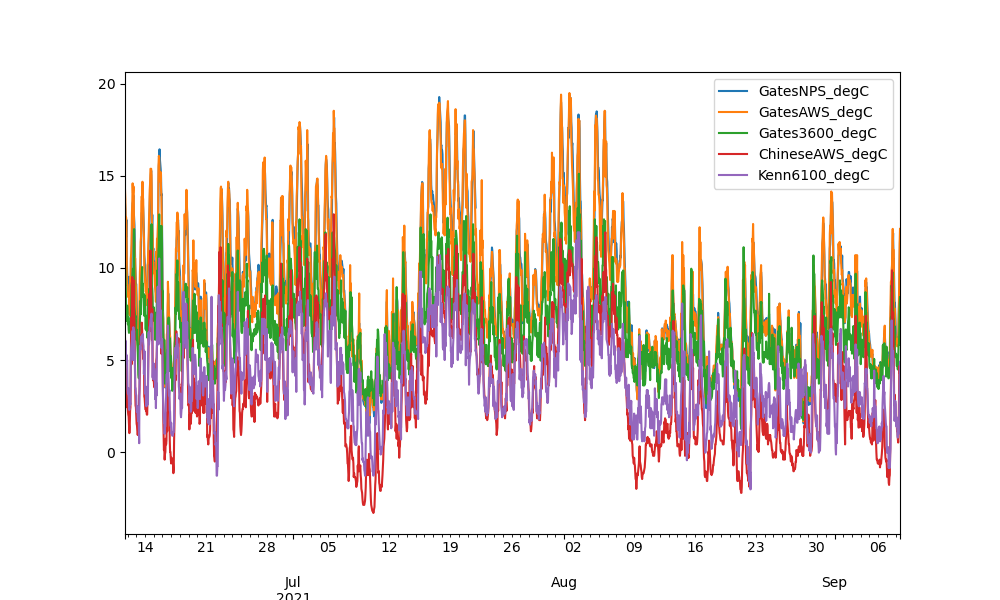

In [2]:
## OPEN CORRECTED HOBO DATA RECORD (these are good Hobo data from June 11-September 8, 2021)

# set working directory
data_dir = r'~/MLo/KennGlac/data'
homogenized = pd.read_pickle(os.path.join(data_dir, 'homogenized_hobos.pickle'))

# view first 2 lines to verify index increment and column headers
print(homogenized.head(2))                             

# set fig size
plt.rcParams["figure.figsize"] = figsize
# Plot data
homogenized.plot();

In [3]:
## COMPARE OVERALL TEMP DIFFERENCES AT ON-GLACIER AND OFF-GLACIER SITES

# create column of hourly differences ('difflower'), then get mean of them and remove diff
homogenized['difflower'] = homogenized['GatesAWS_degC'] - homogenized['Gates3600_degC']
# meandifflower = difference between GatesAWS and Gates3600 in summer 2021
meandifflower=homogenized['difflower'].mean()
print ("Mean of differences between Gates AWS and Gates 3600 = ",meandifflower)

# create column of hourly differences ('diffupper'), then get mean of them and remove diff
homogenized['diffupper'] = homogenized['ChineseAWS_degC'] - homogenized['Kenn6100_degC']
# meandiffupper = difference between ChineseAWS and Kenn6100 in summer 2021
meandiffupper=homogenized['diffupper'].mean()
print ("Mean of differences between Chinese AWS and Kenn 6100 = ",meandiffupper)

# remove unneeded columns
del homogenized['difflower']
del homogenized['diffupper']

Mean of differences between Gates AWS and Gates 3600 =  2.022041229635526
Mean of differences between Chinese AWS and Kenn 6100 =  -0.49042562726372535


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
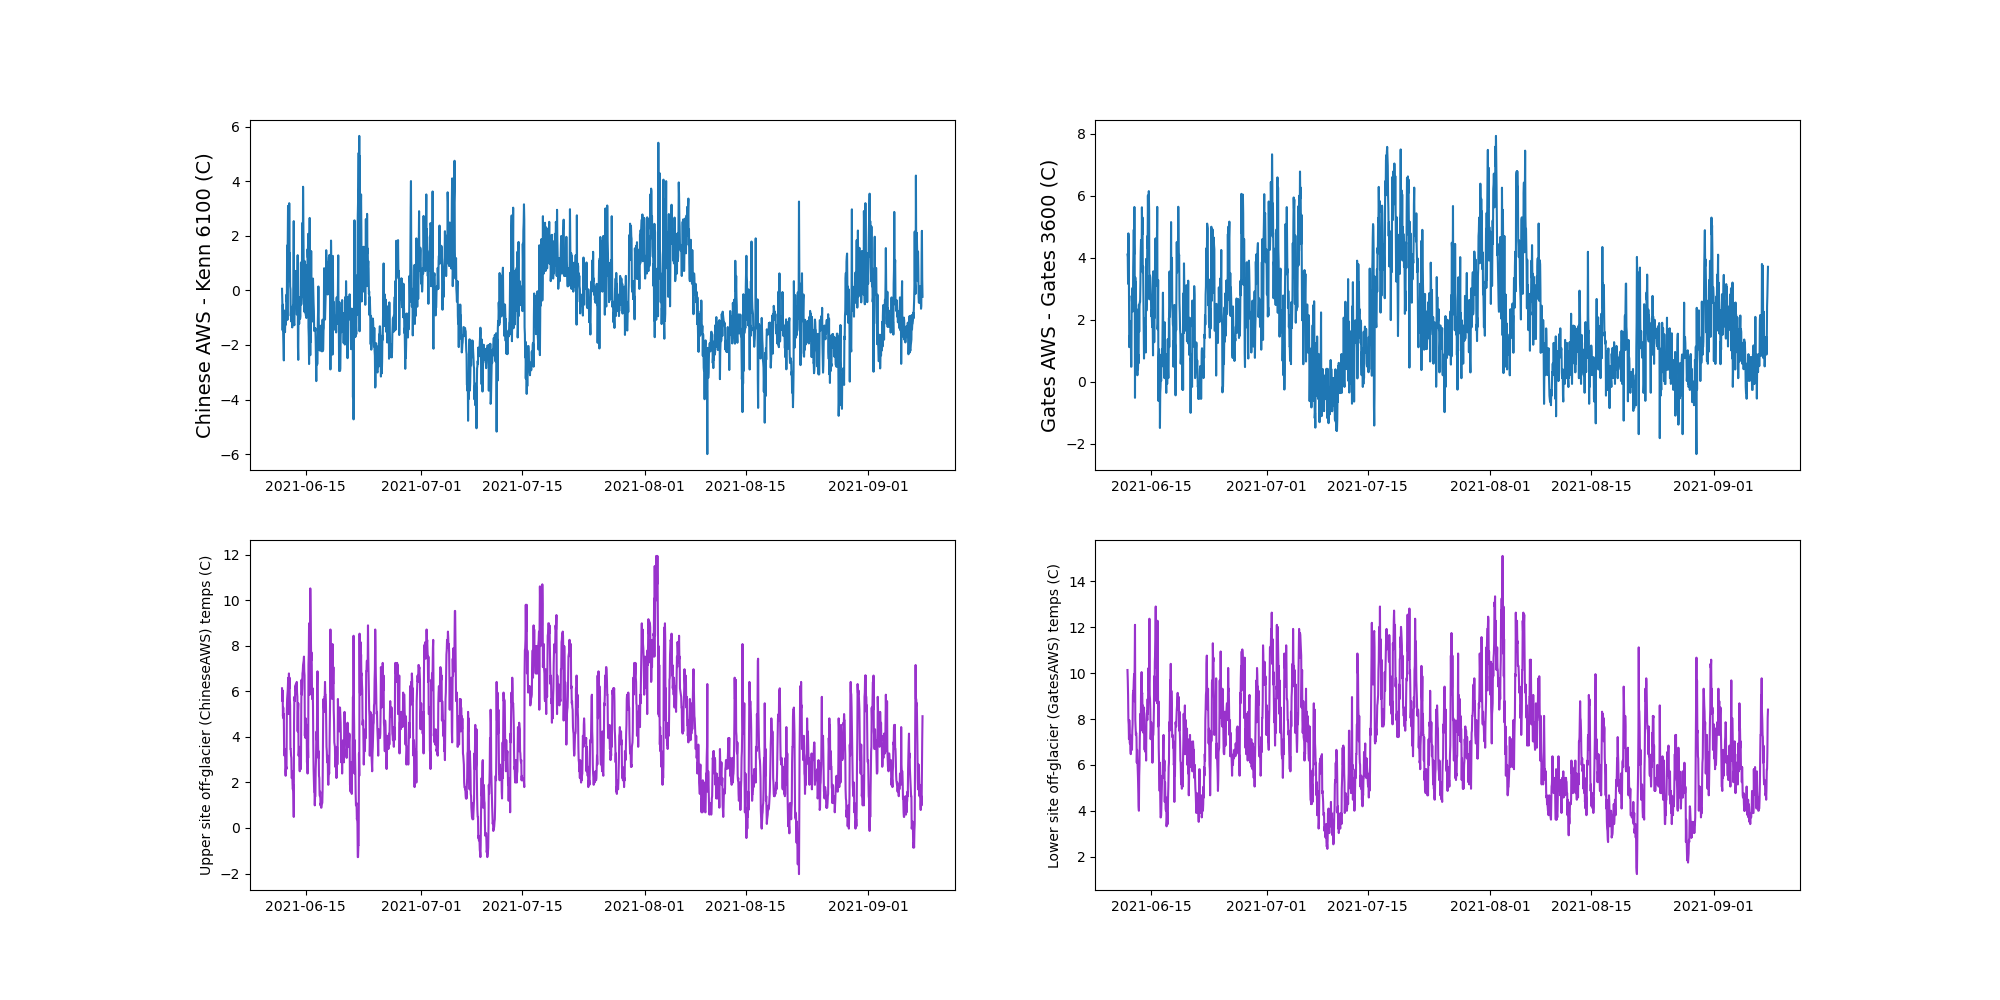

In [4]:
# COMPARE OFF-GLACIER TEMPS TO ON-GLACIER TEMPS AT UPPER AND LOWER COMPARISON SITES

# temp differences subplots for the two sites, plus underneath them the temp records for the on-glacier sites
fig,((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(20,10))
# upper site
ax1.plot(homogenized.ChineseAWS_degC-homogenized.Kenn6100_degC)
ax1.set_ylabel('Chinese AWS - Kenn 6100 (C)',fontsize=14)
# temp record at glacier
ax3.plot(homogenized.Kenn6100_degC,color='darkorchid')
ax3.set_ylabel('Upper site off-glacier (ChineseAWS) temps (C)')
# lower
ax2.plot(homogenized.GatesAWS_degC-homogenized.Gates3600_degC)
ax2.set_ylabel('Gates AWS - Gates 3600 (C)',fontsize=14)
ax4.plot(homogenized.Gates3600_degC,color='darkorchid')
ax4.set_ylabel('Lower site off-glacier (GatesAWS) temps (C)')

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
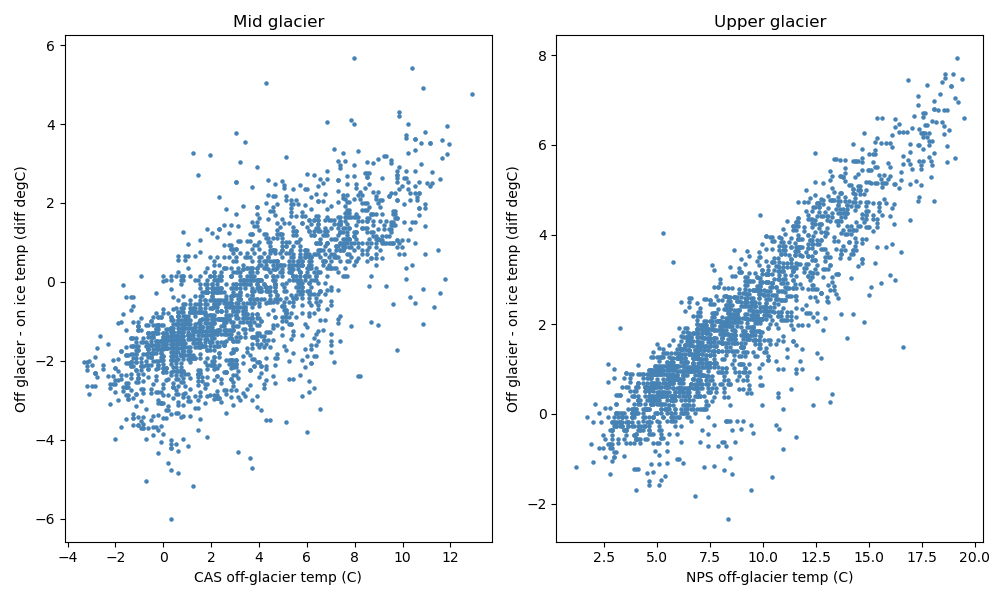

In [5]:
## PLOT ON-VS-OFF GLACIER TEMPERATURE DIFFERENCES AS FUNCTION OF OFF-GLACIER SITE TEMPERATURE

# create subplots
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,6))
# upper site
ax1.scatter(homogenized.ChineseAWS_degC,homogenized.ChineseAWS_degC-homogenized.Kenn6100_degC,color='steelblue',s=5)
ax1.set_title('Mid glacier')
ax1.set_ylabel('Off glacier - on ice temp (diff degC)')
ax1.set_xlabel('CAS off-glacier temp (C)')
# lower site
ax2.scatter(homogenized.GatesAWS_degC,homogenized.GatesAWS_degC-homogenized.Gates3600_degC,color='steelblue',s=5)
ax2.set_title('Upper glacier')
ax2.set_ylabel('Off glacier - on ice temp (diff degC)')
ax2.set_xlabel('NPS off-glacier temp (C)')
fig.tight_layout()
plt.show()

#### Summary
Looks like at both sites, the off-glacier station is significantly warmer on warm days, but similar or colder on cold days. That relationship appears pretty solid at the lower site, but more ambiguous and noisy at the upper site. 

And in general, the differences are greater at the lower site, possibly because the off-glacier site there is frequently snow-free and vegetated, while at the upper site, it is typically snow-covered and/or rocky.

In general, Gates AWS is 2.02 deg warmer than Gates 3600. Chinese AWS is actually, overall, a bit colder than Kenn 6100 (0.49 colder)!

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
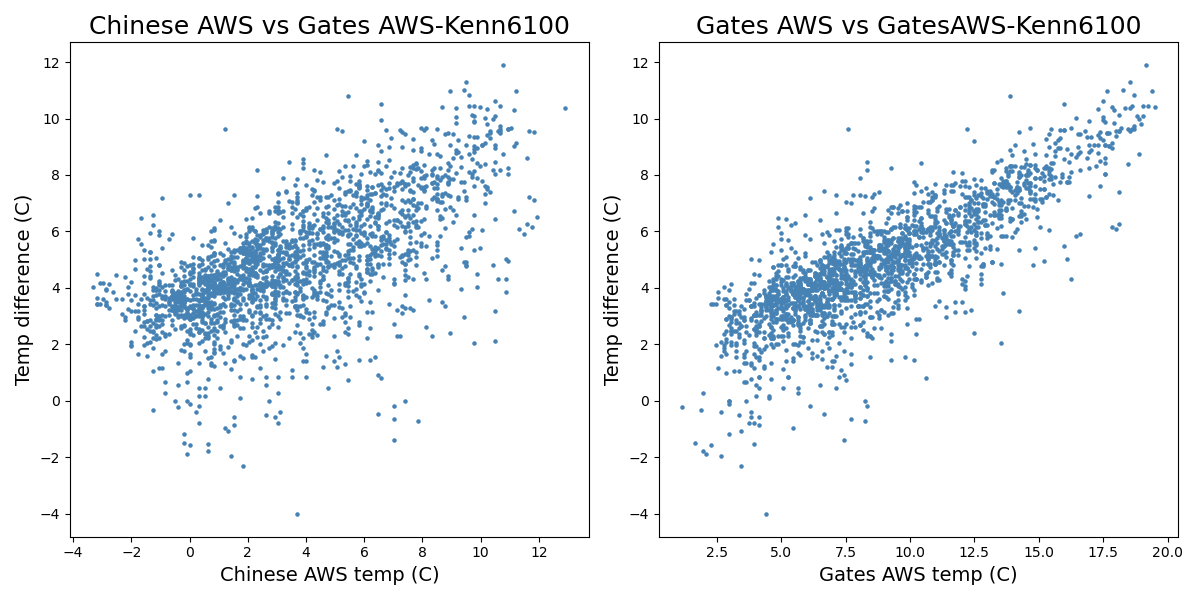

In [6]:
## SEE WHICH OFF-GLACIER SITE HAS A TIGHTER RELATIONSHIP TO ON-GLACIER TEMPS

# set up subplots
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(12,6))

# using Chinese AWS as the x-axis
ax1.scatter(homogenized.ChineseAWS_degC,homogenized.GatesAWS_degC-homogenized.Kenn6100_degC,color='steelblue',s=5)
ax1.set_title('Chinese AWS vs Gates AWS-Kenn6100',fontsize=18)
ax1.set_ylabel('Temp difference (C)',fontsize=14)
ax1.set_xlabel('Chinese AWS temp (C)',fontsize=14)

# using Gates AWS as the x-axis
ax2.scatter(homogenized.GatesAWS_degC,homogenized.GatesAWS_degC-homogenized.Kenn6100_degC,color='steelblue',s=5)
ax2.set_title('Gates AWS vs GatesAWS-Kenn6100',fontsize=18)
ax2.set_ylabel('Temp difference (C)',fontsize=14)
ax2.set_xlabel('Gates AWS temp (C)',fontsize=14)
fig.tight_layout()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
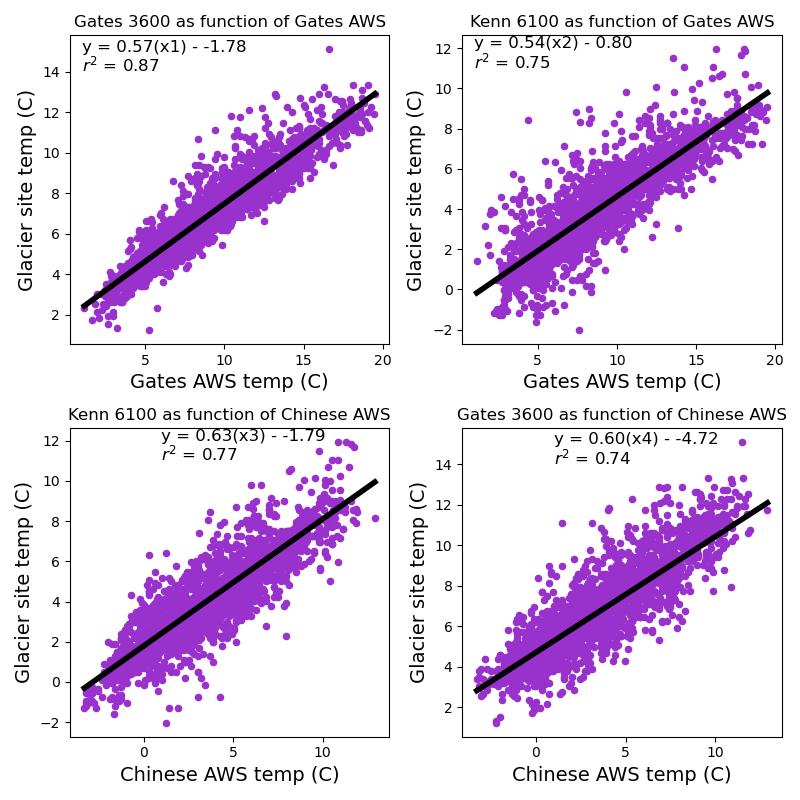

In [7]:
# LINEAR REGRESSION OF THE TWO GLACIER SITES AGAINST EITHER OFF-GLACIER SITE
# note this uses a cumbersome form of regression. see better example below

# plot up
fig,axs = plt.subplots(2,2,figsize=(8,8))

# regression 1 (Gates 3600 as fn of Gates AWS)
x1,y1 = homogenized.GatesAWS_degC,homogenized.Gates3600_degC
slope1, intercept1, r_value, p_value, std_err = stats.linregress(x1,y1)
r2_1 = r_value**2
xo_1 = np.linspace(x1.min(),x1.max())
Yhat_1 = (slope1*xo_1) + intercept1 # regression y coords
axs[0,0].plot(xo_1,Yhat_1,'-',linewidth=4,color='k')
# annotate with r2 and regression equation
axs[0,0].annotate('$r^2$ = {:.2f}'.format(r2_1),(1,14),fontsize=12)
axs[0,0].annotate('y = {0:.2f}(x1) - {1:.2f}'.format(slope1,-intercept1),(1,15),fontsize=12)
# labels
axs[0,0].set_title('Gates 3600 as function of Gates AWS')
axs[0,0].set_ylabel('Glacier site temp (C)',fontsize=14)
axs[0,0].set_xlabel('Gates AWS temp (C)',fontsize=14)

# regression 2 (Kenn 6100 as fn of Gates AWS)
x2,y2 = homogenized.GatesAWS_degC,homogenized.Kenn6100_degC
slope2, intercept2, r_value, p_value, std_err = stats.linregress(x2,y2)
r2_2 = r_value**2
xo_2 = np.linspace(x2.min(),x2.max())
Yhat_2 = (slope2*xo_2) + intercept2 # regression y coords
axs[0,1].plot(xo_2,Yhat_2,'-',linewidth=4,color='k')
# annotate with r2 and regression equation
axs[0,1].annotate('$r^2$ = {:.2f}'.format(r2_2),(1,11),fontsize=12)
axs[0,1].annotate('y = {0:.2f}(x2) - {1:.2f}'.format(slope2,-intercept2),(1,12),fontsize=12)
# labels
axs[0,1].set_title('Kenn 6100 as function of Gates AWS')
axs[0,1].set_ylabel('Glacier site temp (C)',fontsize=14)
axs[0,1].set_xlabel('Gates AWS temp (C)',fontsize=14)

# regression 3 (Kenn 6100 as fn of Chinese AWS)
x3,y3 = homogenized.ChineseAWS_degC,homogenized.Kenn6100_degC
slope3, intercept3, r_value, p_value, std_err = stats.linregress(x3,y3)
r2_3 = r_value**2
xo_3 = np.linspace(x3.min(),x3.max())
Yhat_3 = (slope3*xo_3) + intercept3 # regression y coords
axs[1,0].plot(xo_3,Yhat_3,'-',linewidth=4,color='k')
# annotate with r2 and regression equation
axs[1,0].annotate('$r^2$ = {:.2f}'.format(r2_3),(1,11),fontsize=12)
axs[1,0].annotate('y = {0:.2f}(x3) - {1:.2f}'.format(slope3,-intercept3),(1,12),fontsize=12)
# labels
axs[1,0].set_title('Kenn 6100 as function of Chinese AWS')
axs[1,0].set_ylabel('Glacier site temp (C)',fontsize=14)
axs[1,0].set_xlabel('Chinese AWS temp (C)',fontsize=14)

# regression 4 (Gates 3600 as fn of Chinese AWS)
x4,y4 = homogenized.ChineseAWS_degC,homogenized.Gates3600_degC
slope4, intercept4, r_value, p_value, std_err = stats.linregress(x4,y4)
r2_4 = r_value**2
xo_4 = np.linspace(x4.min(),x4.max())
Yhat_4 = (slope1*xo_4) + intercept4 # regression y coords
axs[1,1].plot(xo_4,Yhat_4,'-',linewidth=4,color='k')
# annotate with r2 and regression equation
axs[1,1].annotate('$r^2$ = {:.2f}'.format(r2_4),(1,14),fontsize=12)
axs[1,1].annotate('y = {0:.2f}(x4) - {1:.2f}'.format(slope4,-intercept4),(1,15),fontsize=12)
# labels
axs[1,1].set_title('Gates 3600 as function of Chinese AWS')
axs[1,1].set_ylabel('Glacier site temp (C)',fontsize=14)
axs[1,1].set_xlabel('Chinese AWS temp (C)',fontsize=14)


axs[0,0].scatter(x1,y1,color='darkorchid',s=20)
axs[0,1].scatter(x2,y2,color='darkorchid',s=20)
axs[1,0].scatter(x3,y3,color='darkorchid',s=20)
axs[1,1].scatter(x4,y4,color='darkorchid',s=20)

fig.tight_layout()
plt.show()

### Summary 
Using just a simple regression, it looks like I can predict on-glacier temps at Gates 3600 way better from Gates AWS than from Chinese AWS, and I can predict them a little better at Kenn 6100 using Gates AWS. Seems to justify using Gates AWS as the main tool. But before doing do, let's see if it works as well to predict Gates 3600 from Gates AWS, and then use a simple lapse rate to get temps at Kenn 6100.

In [8]:
## A MUCH SIMPLER WAY TO DO A SIMPLE LINEAR REGRESSION

# Gates 3600 as a function of Gates AWS
regr=smf.ols(formula='Gates3600_degC ~ GatesAWS_degC', data=homogenized).fit()

print(regr.params)
print(regr.summary())

Intercept        1.775760
GatesAWS_degC    0.571476
dtype: float64
                            OLS Regression Results                            
Dep. Variable:         Gates3600_degC   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                 1.488e+04
Date:                Thu, 10 Feb 2022   Prob (F-statistic):               0.00
Time:                        12:59:54   Log-Likelihood:                -2541.4
No. Observations:                2132   AIC:                             5087.
Df Residuals:                    2130   BIC:                             5098.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

In [9]:
## INFER KENN6100 TEMPS FROM REGRESSED GATES3600 TEMPS, USING JUST A LAPSE RATE

# fyi, Tristan inferred a glacier-wide lapse rate of -4.06 degC / km
# Elevs: Gates AWS = 1237.5, Gates3600 = 1070, ChineseAWS = 2185, Kenn6100 = 1830

lr=-4.06

## PREDICT GATES3600 TEMPS FROM REGRESSION OFF GATES AWS THEN USE TRISTAN'S LAPSE RATE TO CALCULATE KENN6100 VALUES
homogenized['Kenn6100recon'] = 1.775760+homogenized.GatesAWS_degC*0.571476 + lr*(1830-1070)*.001
# Kenn6100recon is temps at 6100 inferred from regression/lapse rate at GatesAWS

homogenized.head(2)

## FOR COMPARISON, REGRESS KENN6100 against CHINESE AWS
regr1=smf.ols(formula='Kenn6100_degC ~ ChineseAWS_degC', data=homogenized).fit()
print(regr1.params)
print(regr1.summary())

## PREDICT KENN6100 TEMPS DIRECTLY FROM CHINESE AWS
homogenized['Kenn6100reconFROMchinese']=homogenized.ChineseAWS_degC*regr1.params.ChineseAWS_degC + regr1.params.Intercept

print(homogenized.head(2))

Intercept          1.785232
ChineseAWS_degC    0.631724
dtype: float64
                            OLS Regression Results                            
Dep. Variable:          Kenn6100_degC   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     7227.
Date:                Thu, 10 Feb 2022   Prob (F-statistic):               0.00
Time:                        12:59:55   Log-Likelihood:                -3235.4
No. Observations:                2132   AIC:                             6475.
Df Residuals:                    2130   BIC:                             6486.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
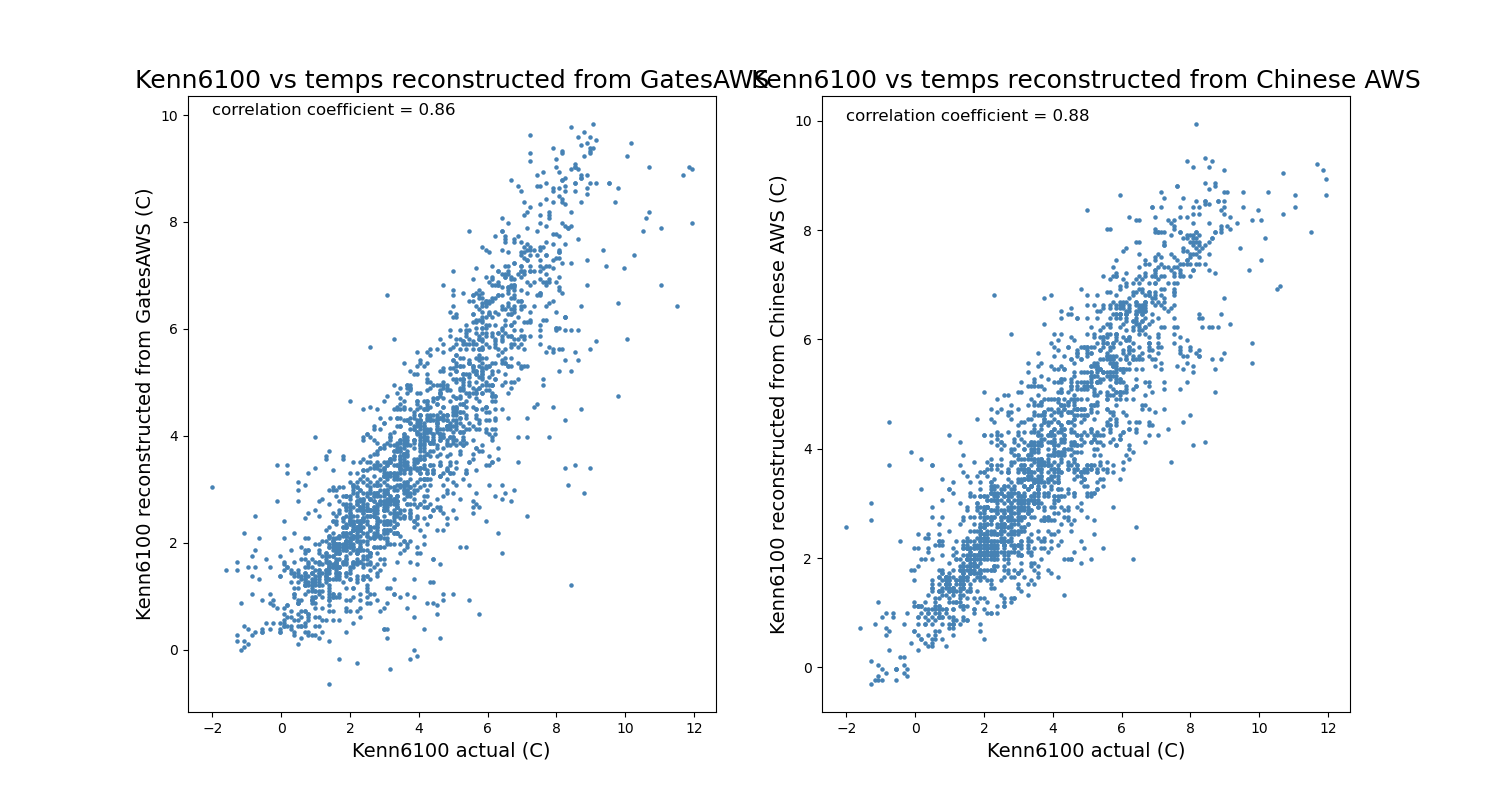

In [10]:
## COMPARE ACTUAL KENN 6100 TEMPS TO THOSE RECONSTRUCTED FROM GATES (REGRESS+LAPSE RATE) AND FROM CHINESE AWS REGRESS

# set up subplots
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,8))

# From GatesAWS using measured kenn6100 as the x-axis
ax1.scatter(homogenized.Kenn6100_degC,homogenized.Kenn6100recon,color='steelblue',s=5)
ax1.set_title('Kenn6100 vs temps reconstructed from GatesAWS',fontsize=18)
ax1.set_ylabel('Kenn6100 reconstructed from GatesAWS (C)',fontsize=14)
ax1.set_xlabel('Kenn6100 actual (C)',fontsize=14)

# calculate and annotate correlation coefficient
corr1 = np.corrcoef(homogenized.Kenn6100_degC,homogenized.Kenn6100recon)
ax1.annotate('correlation coefficient = {:.2f}'.format(corr1[0,1]),(-2,10),fontsize=12)


# From Chinese AWS using measured kenn6100 as the x-axis
ax2.scatter(homogenized.Kenn6100_degC,homogenized.Kenn6100reconFROMchinese,color='steelblue',s=5)
ax2.set_title('Kenn6100 vs temps reconstructed from Chinese AWS',fontsize=18)
ax2.set_ylabel('Kenn6100 reconstructed from Chinese AWS (C)',fontsize=14)
ax2.set_xlabel('Kenn6100 actual (C)',fontsize=14)

# calculate and annotate correlation coefficient
corr2 = np.corrcoef(homogenized.Kenn6100_degC,homogenized.Kenn6100reconFROMchinese)
ax2.annotate('correlation coefficient = {:.2f}'.format(corr2[0,1]),(-2,10),fontsize=12)

plt.show()

### Summary

There is a good relationship between temps at Gates AWS (off-glacier) and Gates 3600 (on-glacier). There is a similar, but messier, relationship between temps at Chinese AWS (off-glacier) and Kenn 6100 (on-glacier). In both cases, temperatures on the glacier are significantly cooler than their off-glacier counterparts when it is warm out, but as temperatures at the off-glacier site get cooler and approach zero, the difference diminishes and then eventually reverses, to where the off-glacier site (which in both cases is at a higher elevation) becomes cooler than the on-glacier site. This relationship can't be trusted below zero C, because we don't have good data for that time period, but we don't really care because we are only interested in positive degree days, which we can calculate pretty well from the warmer days at Gates. 

Overall, Gates 3600 is on AVERAGE 2.0 degrees cooler than Gates AWS. But that said, we can model the relationship better as Gates 3600 = 0.57 x Gates AWS +1.78. This has an r2 of 0.88.

So to predict temps at Kenn 6100 (which we know for this past summer), I tried two approaches. 1) Calculate on-ice temp at Gates 3600 from the relationship above, then use the lapse rate of -4.06 degC/km (from Tristan's work) to calculate the temp there. Or 2) Calculate on-ice temp at Kenn 6100 directly from Chinese AWS. That's what I've done above, and the prediction using Gates AWS is nearly as good (correlation coefficient = 0.86, vs r2=0.88 when basing off Kenn 6100). So I think that's the way to go, given that Gates AWS is a long-term consistent record and Chinese AWS is not. 

Next step is to re-calculate lapse rates that reflect on-ice temperatures (instead of blindly relying on Tristan's lr)

In [11]:
# CALCULATE BEST ON-ICE LAPSE RATE BASED ON GATES 3600 AND KENN 6100 DATA

# lapse rate from Tristan = -4.06 degC / km  (this variable is 'lr'
# Elevs: Gates AWS = 1237.5, Gates3600 = 1070, ChineseAWS = 2185, Kenn6100 = 1830

homogenized['diff2'] = homogenized['Kenn6100_degC'] - homogenized['Gates3600_degC']
print ("Mean of differences between Kenn6100 and Gates3600 = ",homogenized['diff2'].mean())

# calculate on-ice lapse rate ('lr2')
lr2=homogenized['diff2'].mean() / (1830-1070) * 1000
print(lr2)

Mean of differences between Kenn6100 and Gates3600 =  -2.834194153861738
-3.7292028340286025


## Summary: lapse rates
Actual measured lapse rate from Gates 3600-Kenn 6100: -3.72
Tristan's estimated glacier-wide (summer) lapse rate: -4.06

I like it! So for upper glacier we have a measured lapse rate of -3.72. Now let's look down glacier to see how the relationship holds up down there. Tricky because we have no on-ice measurements down there. One strategy would be to use -4.06, or -3.72, everywhere, using the regression of GatesAWS to Gates3600 to create our 'base temperature'. 

But let's compare on-glacier temps at Gates 3600 to temps at the river (off-glacier, but a cold spot)

In [12]:
## LOAD KENN RIVER AIR TEMP DATA (AIR TEMP DEG C)

# set working directory
data_dir = r'~/MLo/KennGlac/data'
# Load an excel workbook that is in the local directory
xlsx=pd.ExcelFile(os.path.join(data_dir,'KENNRIVER 15min airtemp 2016_05_26 to 2021_11_11.xlsx'))
# Load the first worksheet ('kr' = kennicott river, treat -9999 as nan|, make first column (dates) the index, header is on row 15, use only columns 2 and 3 (everything starts with 0)
kr=pd.read_excel(xlsx,na_values=['False'],index_col=0,header=14,usecols=(1,2))

                       Value
Timestamp (UTC-09:00)       
2016-05-26 19:00:00     16.9
2016-05-26 19:15:00     15.4
Value    float64
dtype: object
(170746, 1)


<AxesSubplot:xlabel='Timestamp (UTC-09:00)'>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
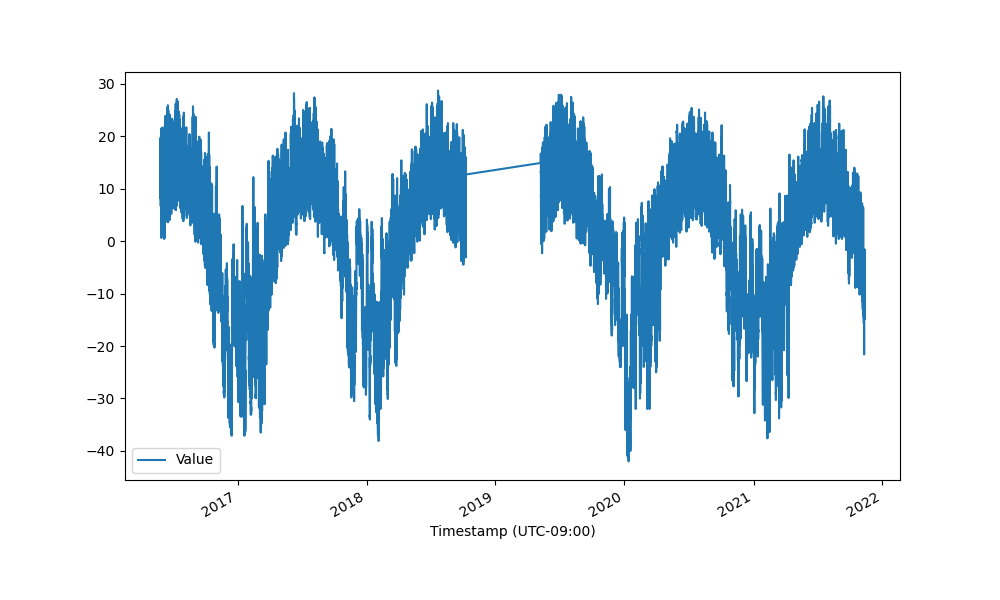

In [13]:
## VIEW KENN RIVER AIR TEMP DATA

# Print summary of worksheet
print(kr.head(2))

# Print datatypes (dtypes) of DataFrame (wb)
print(kr.dtypes)

# Summarize size of worksheet
print(kr.shape)

# Plot data, set fig size
plt.rcParams["figure.figsize"] = figsize
kr.plot()

(47885, 1)
KennRiver_degC    float64
dtype: object


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
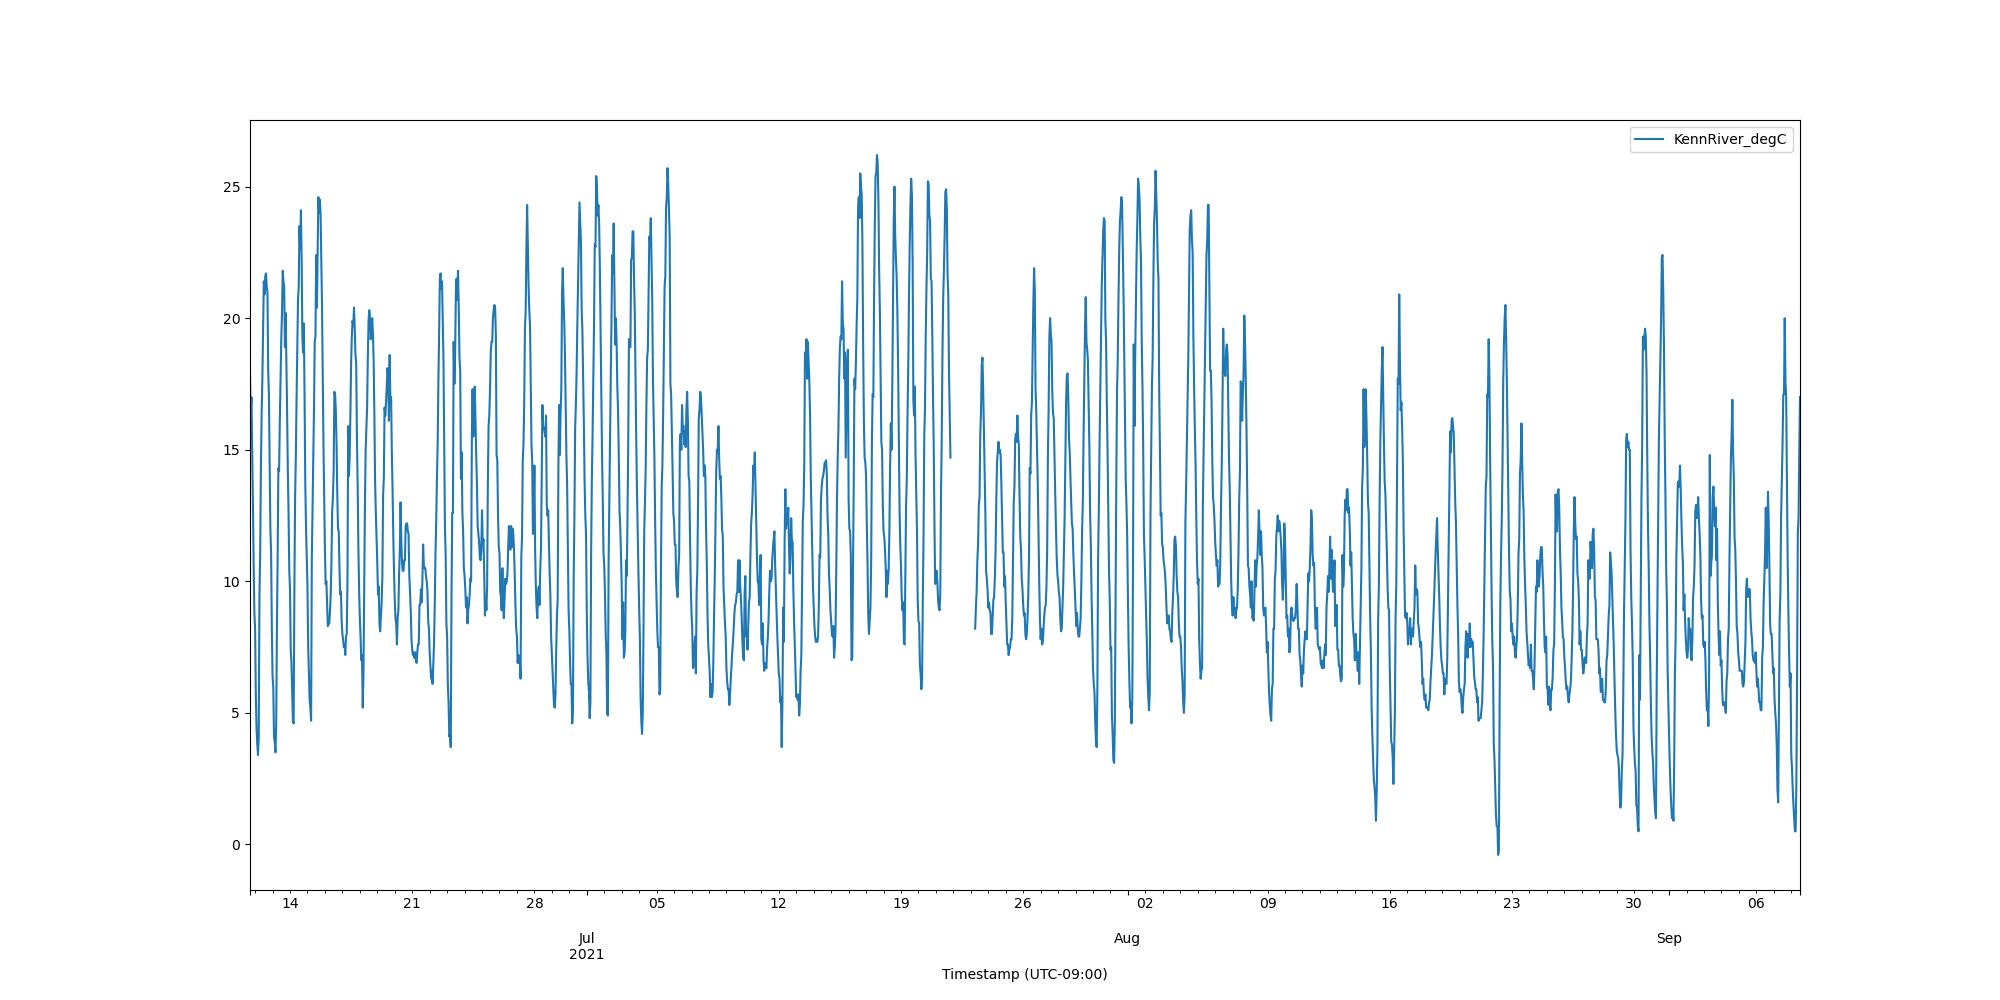

In [14]:
# CONVERT 15 MINUTE VALUES TO HOURLY, SLICE TO DESIRED TIME FRAME, AND VIEW

# these are 15 minute values. Convert to hourly (by selecting only the hourly values)
kr_hr=kr.resample('60min').first()

# rename column
kr_hr.rename(columns = {'Value':'KennRiver_degC'},inplace=True)

# Summarize size of worksheet
print(kr_hr.shape)

print(kr_hr.dtypes)

# get slice of Kenn River data that matches hobo data
kr21=kr_hr[datetime.datetime(2021,6,11,17,0,0):datetime.datetime(2021,9,8,12,0,0)]

# check for null values. There seem to be 33 in the time series from 2021
# find null values
np.where(pd.isnull(kr21))
# show null values
# print(kr21.iloc[964:996,:])

# Plot data (kr21, the hourly Kennicott River air temp data for 2021), set fig size
plt.rcParams["figure.figsize"] = (20,10)
kr21.plot()
plt.show()

In [15]:
## CLEAN UP OUR DATAFRAME

# clean up homogenized
del homogenized['diff2']
del homogenized['Kenn6100recon']
del homogenized['Kenn6100reconFROMchinese']

print(homogenized.head())

                     GatesNPS_degC  GatesAWS_degC  Gates3600_degC  \
2021-06-11 17:00:00          13.50      14.241805       10.138496   
2021-06-11 18:00:00          13.11      13.712867        9.686813   
2021-06-11 19:00:00          11.83      12.209868        9.051794   
2021-06-11 20:00:00          11.67      12.741361        7.954850   
2021-06-11 21:00:00          12.61      12.387203        7.770489   

                     ChineseAWS_degC  Kenn6100_degC  
2021-06-11 17:00:00         6.187286       6.128125  
2021-06-11 18:00:00         5.147477       5.565316  
2021-06-11 19:00:00         4.574012       6.034749  
2021-06-11 20:00:00         4.381934       4.903007  
2021-06-11 21:00:00         3.705966       5.282636  


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
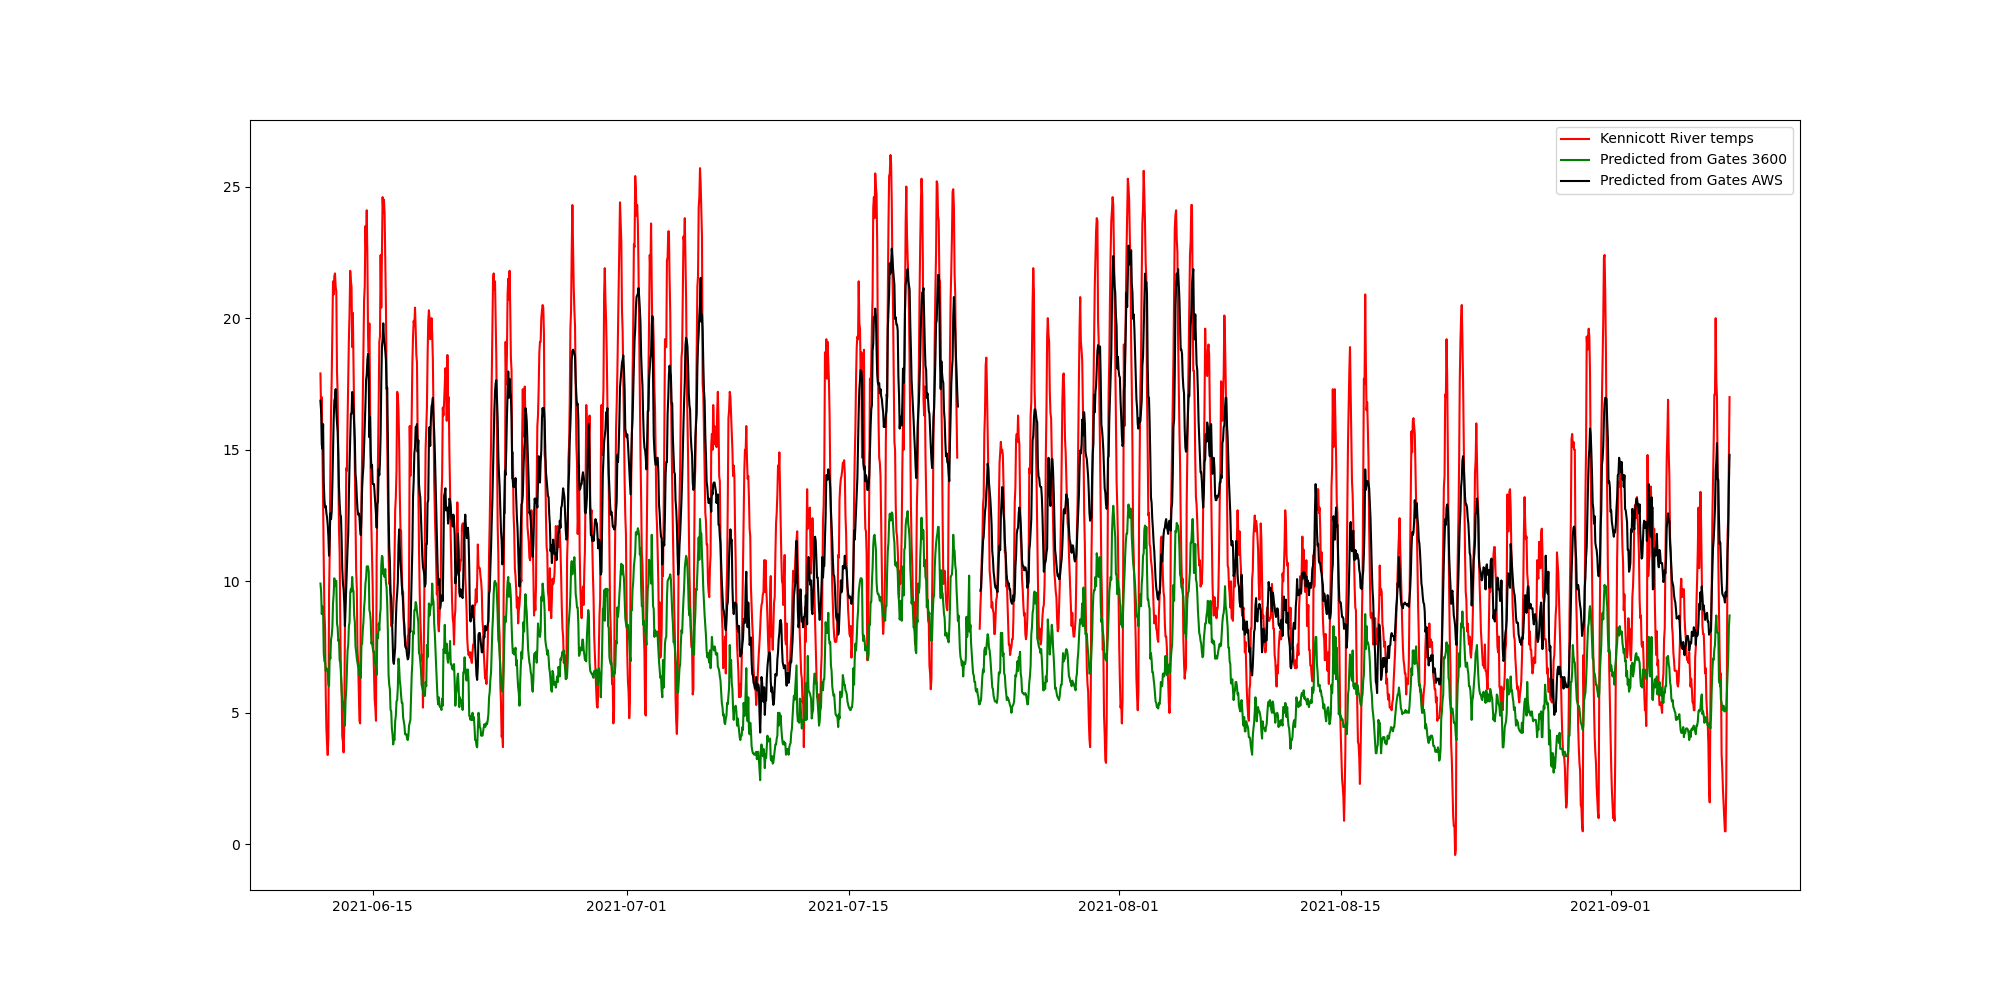

In [16]:
## NOW COMPARE kr21 TO THE DATA AT GATES 3600

fig=plt.subplots()

# calculate Gates 3600 as function of Gates RAWS
homogenized['Gates3600recon'] = 1.7758+homogenized['GatesAWS_degC']*0.5715

# use on-ice lapse rate (-3.72) to predict kenn river temps (Kenn River at 409 m)
homogenized['kr_recon']=homogenized['Gates3600recon'] + (409-1070)*.001*-3.72 

fig=plt.plot(kr21,color="red")
fig=plt.plot(homogenized.Gates3600recon,color="green")


## It doesn't look very good. The reconstruction is too cold and has too limited of a temperature range. 
# What if we reconstruct kr (which is off-glacier) from the off-glacier correlate (Gates AWS) directly?

homogenized['kr_recon_fromRAWS'] = homogenized.GatesNPS_degC + (409-1237.5)*.001*-4.06 

# and plot that

fig=plt.plot(homogenized.kr_recon_fromRAWS,color='black')

plt.legend(['Kennicott River temps','Predicted from Gates 3600','Predicted from Gates AWS'])

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
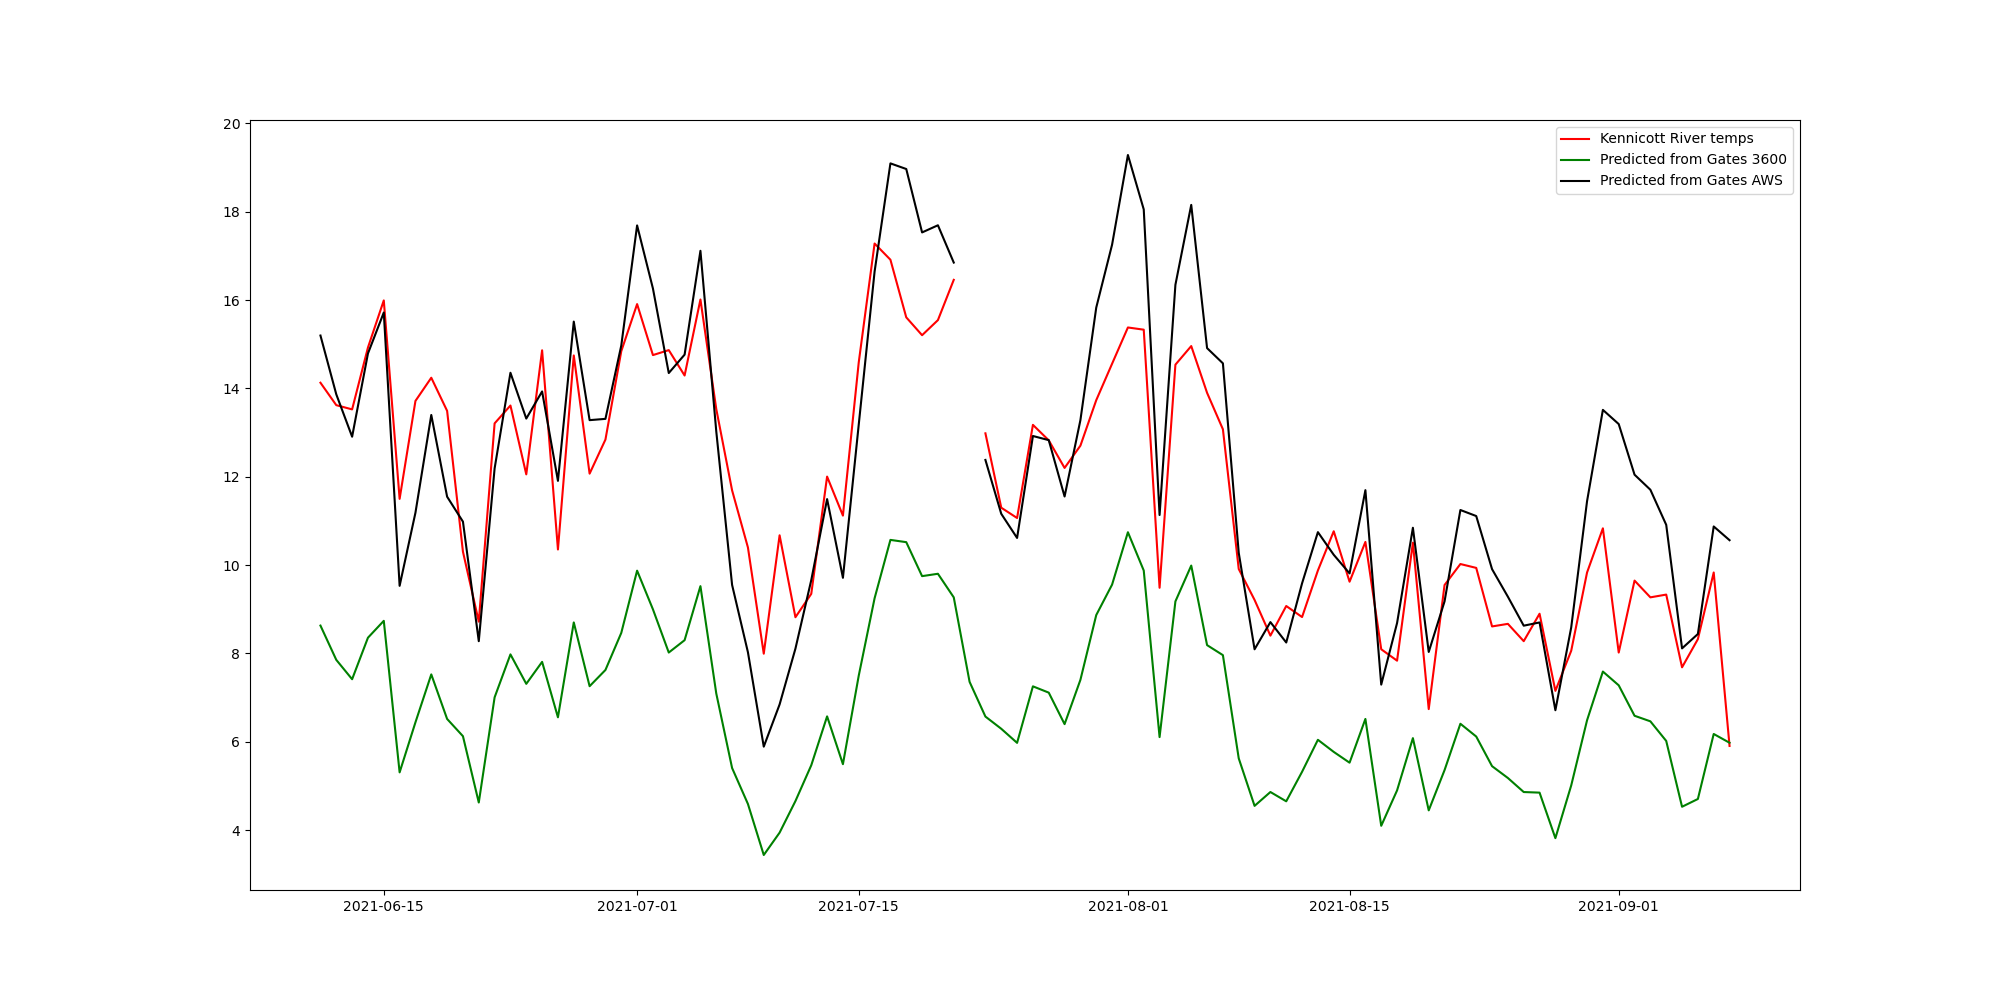

In [17]:
## REPEAT ABOVE ANALYSIS (COMPARE KR21 TO GATES 3600) BUT USING DAILY VALUES

fig=plt.subplots()

# resample whole homogenized table as daily values
daily=homogenized.resample('D').mean()
# resample kr21 as daily
dailykr21=kr21.resample('D').mean()

fig=plt.plot(dailykr21,color="red")
fig=plt.plot(daily.Gates3600recon,color="green")
fig=plt.plot(daily.kr_recon_fromRAWS,color='black')

plt.legend(['Kennicott River temps','Predicted from Gates 3600','Predicted from Gates AWS'])

plt.show()

### Summary
If we wanted to predict kennicott river temps from our data, we would do a simple lapse rate calculation using the Gates AWS stuff. That's pretty clear from the daily values above. But we don't really want that, do we? What we really want is the temps on the lower glacier. Those MAY be well predicted from Gates AWS, but we have another possibility--that they are well-predicted from the Kenn River sensor. Then we would just have to decide where to divide lower glaciers temps (reconstructed from Kenn River) from upper glacier temps (reconstructed from Gates AWS). Let's play around with all that.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
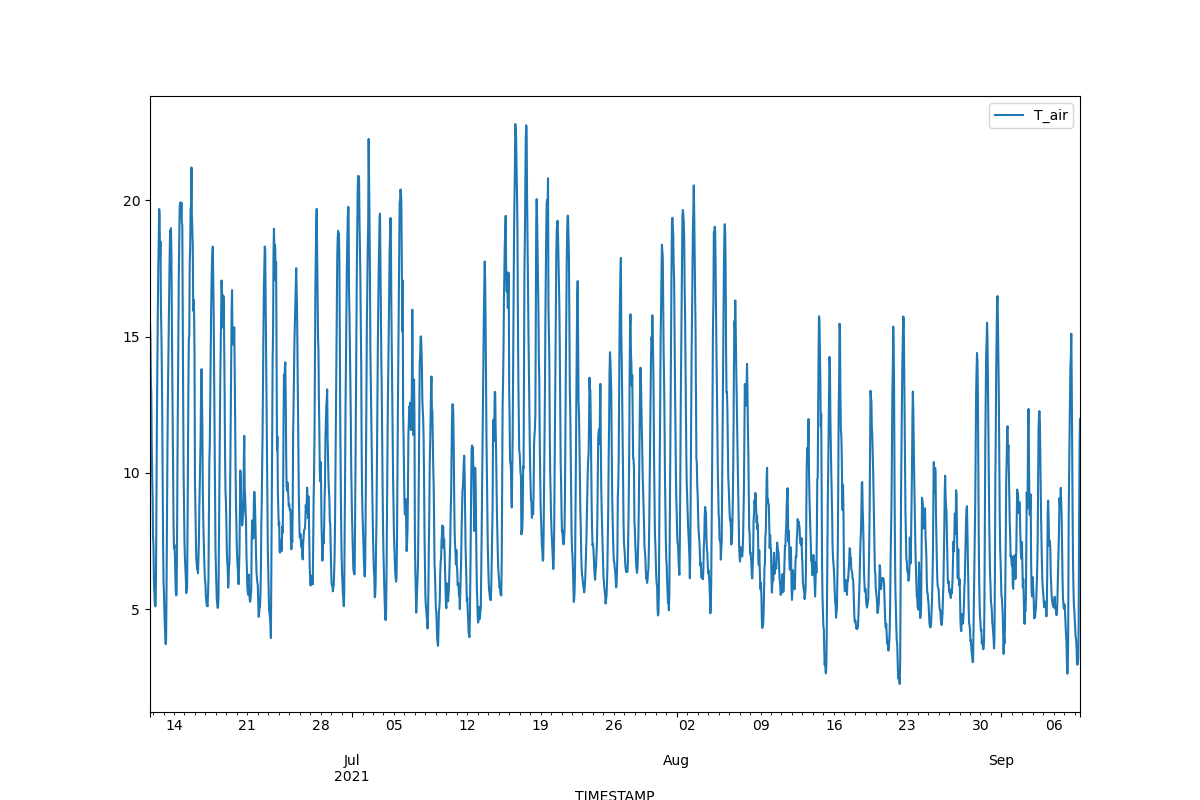

In [18]:
## LOAD UP ON-GLACIER TEMP DATA FROM ERIC

# set working directory
data_dir = r'~/MLo/KennGlac/data/Raw_Climate_Records/current 2021/PETERSEN'
# Load an excel workbook that is in the local directory
csv=os.path.join(data_dir,'AWS_debris_2021_60min.csv')
# Load the first worksheet as 'esp', treat -9999 as nan|, make first column (dates) the index
esp=pd.read_csv(csv,na_values=[-9999],header=0,index_col=0,parse_dates=['TIMESTAMP'],usecols=['TIMESTAMP','T_air'])

# Slice to desired times

# get slice of Kenn River data that matches hobo data
esp=esp[datetime.datetime(2021,6,11,17,0,0):datetime.datetime(2021,9,8,12,0,0)]

# check for null values. There seem to be 33 in the time series from 2021
# find null values
np.where(pd.isnull(esp))
# show null values
# print(kr21.iloc[964:996,:])

# Plot data (esp, the hourly Eric Simon Petersen air temp data for 2021), set fig size
plt.rcParams["figure.figsize"] = (12,8)
esp.plot()
plt.show()

# print(esp.head())

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
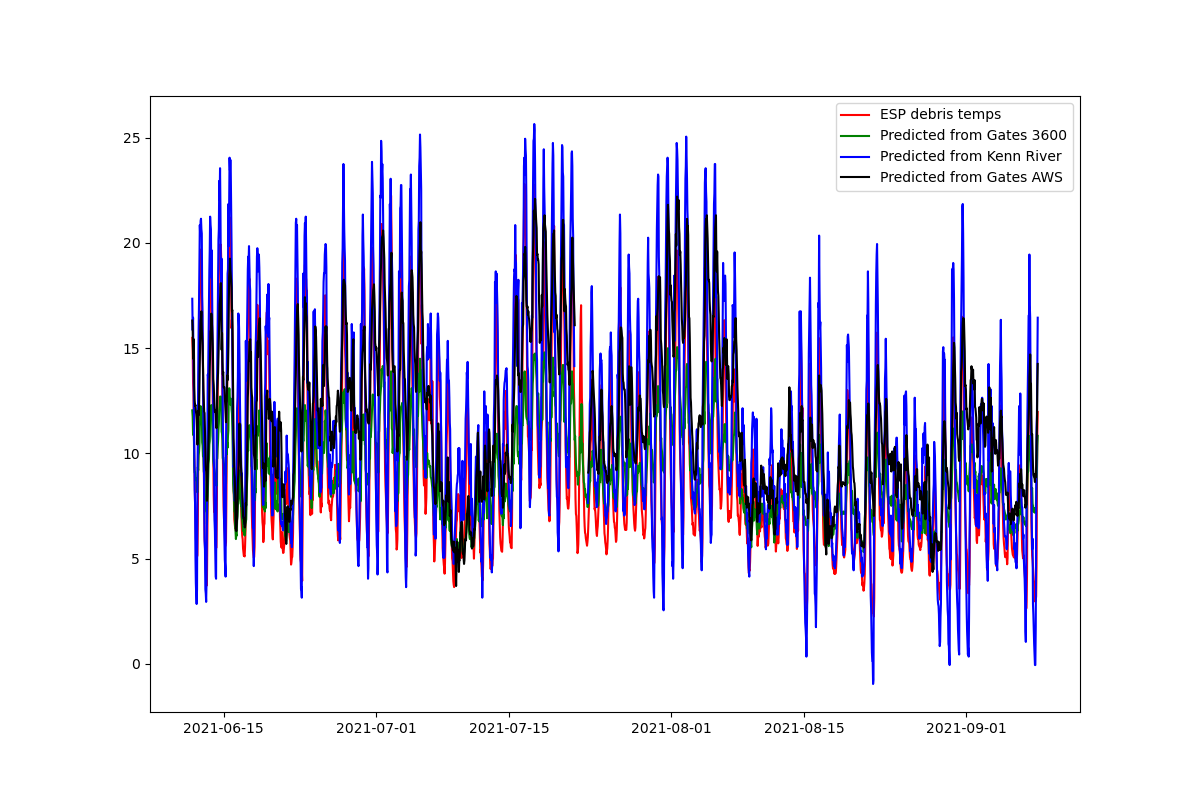

In [19]:
## NOW COMPARE ESB TO THE DATA AT GATES 3600 AND TO KENN RIVER
# Eric's met station was at 546 m

fig=plt.subplots()

# use on-ice lapse rate (-3.72) to predict esp temps from Gates 3600
homogenized['esp_recon_Gates3600recon']=homogenized['Gates3600recon'] + (546-1070)*.001*-4.06 # 3.72 might make more sense for clean ice? too cold for on the debris

# use off-ice lapse rate (-4.06) to predict esp temps from Kenn River temps
homogenized['esp_recon_KennRiverrecon']=kr21 + (546-409)*.001*-4.06 

# use off-ice lapse rate (-4.06) to predict esp temps from Gates AWS temps
homogenized['esp_recon_GatesAWSrecon']=homogenized['GatesNPS_degC'] + (546-1237.5)*.001*-4.06 

# plot them all
fig=plt.plot(esp,color="red")
fig=plt.plot(homogenized.esp_recon_Gates3600recon,color="green")
fig=plt.plot(homogenized.esp_recon_KennRiverrecon,color='blue')
fig=plt.plot(homogenized.esp_recon_GatesAWSrecon,color='black')


plt.legend(['ESP debris temps','Predicted from Gates 3600','Predicted from Kenn River','Predicted from Gates AWS'])
plt.rcParams["figure.figsize"] = (12,6)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
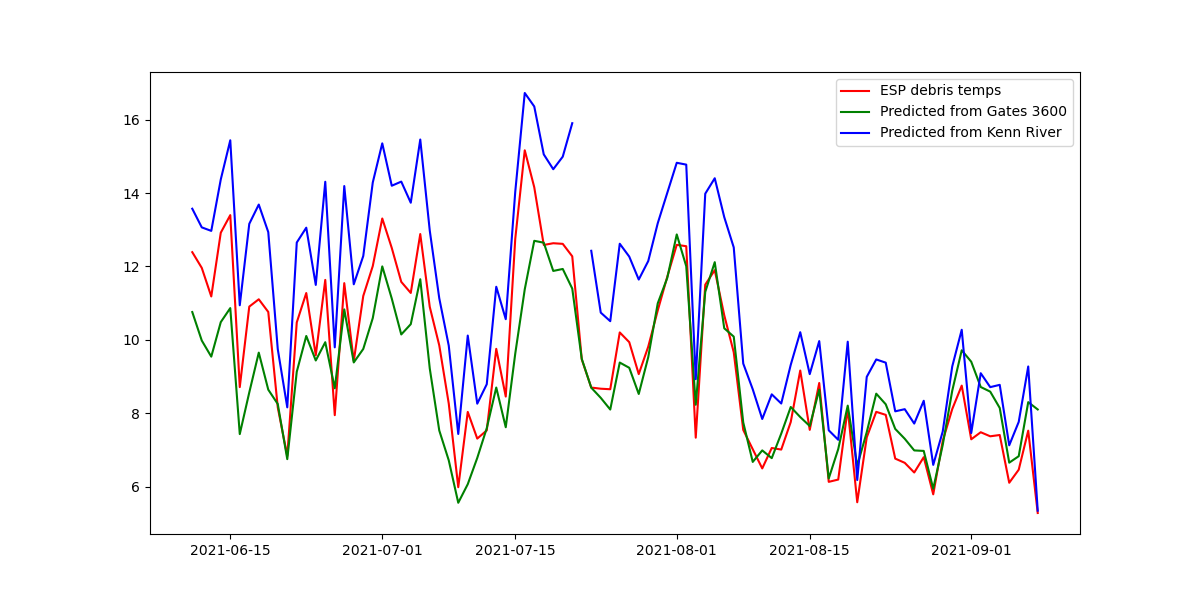

In [20]:
## REPEAT ABOVE ANALYSIS (COMPARE ESP TO VARIOUS RECONSTRUCTIONS) BUT USING DAILY VALUES

fig=plt.subplots()

# resample whole homogenized table as daily values
daily=homogenized.resample('D').mean()
# resample esp as daily
daily['esp']=esp.resample('D').mean()

# plot them all
fig=plt.plot(daily.esp,color="red")
fig=plt.plot(daily.esp_recon_Gates3600recon,color="green")
fig=plt.plot(daily.esp_recon_KennRiverrecon,color='blue')
#fig=plt.plot(daily.esp_recon_GatesAWSrecon,color='black')

plt.legend(['ESP debris temps','Predicted from Gates 3600','Predicted from Kenn River','Predicted from Gates AWS'])
plt.rcParams["figure.figsize"] = (12,6)
plt.show()

In [21]:
## CHECK CORRELATIONS

# calculate and annotate correlation coefficient (use pandas correlation calculator because it will ignore nans)
daily.corr()

,GatesNPS_degC,GatesAWS_degC,Gates3600_degC,ChineseAWS_degC,Kenn6100_degC,Gates3600recon,kr_recon,kr_recon_fromRAWS,esp_recon_Gates3600recon,esp_recon_KennRiverrecon,esp_recon_GatesAWSrecon,esp
GatesNPS_degC,1.000000,0.998484,0.987809,0.941715,0.939576,0.998484,0.998484,1.000000,0.998484,0.879104,1.000000,0.882830
GatesAWS_degC,0.998484,1.000000,0.988786,0.941161,0.937226,1.000000,1.000000,0.998484,1.000000,0.885558,0.998484,0.893549
Gates3600_degC,0.987809,0.988786,1.000000,0.933428,0.937987,0.988786,0.988786,0.987809,0.988786,0.895351,0.987809,0.905758
ChineseAWS_degC,0.941715,0.941161,0.933428,1.000000,0.940000,0.941161,0.941161,0.941715,0.941161,0.813326,0.941715,0.807539
Kenn6100_degC,0.939576,0.937226,0.937987,0.940000,1.000000,0.937226,0.937226,0.939576,0.937226,0.864814,0.939576,0.873238
Gates3600recon,0.998484,1.000000,0.988786,0.941161,0.937226,1.000000,1.000000,0.998484,1.000000,0.885558,0.998484,0.893549
kr_recon,0.998484,1.000000,0.988786,0.941161,0.937226,1.000000,1.000000,0.998484,1.000000,0.885558,0.998484,0.893549
kr_recon_fromRAWS,1.000000,0.998484,0.987809,0.941715,0.939576,0.998484,0.998484,1.000000,0.998484,0.879104,1.000000,0.882830
esp_recon_Gates3600recon,0.998484,1.000000,0.988786,0.941161,0.937226,1.000000,1.000000,0.998484,1.000000,0.885558,0.998484,0.893549
esp_recon_KennRiverrecon,0.879104,0.885558,0.895351,0.813326,0.864814,0.885558,0.885558,0.879104,0.885558,1.000000,0.879104,0.980513


### Summary
It looks like Gates 3600 is much better at predicting temps at the ESP AWS than the Gates AWS. I checked with correlations though and the river is best. ESP (at daily) correlates with Gates 3600 at 0.89, with Gates AWS at 0.88, and with KennRiver recon at 0.98. --just the lapse rate is off. You can clearly see that the Gates AWS predicts much too high temps on hot days--even on the debris where we would expect more solar heating, so the strategy of reconstructing glacier temps from the regressed (predicted) temps at Gates 3600 is a good one. 

Interesting trend of the Gates3600 reconstruction starting a little too cold, and by the end too hot. Either Gates is warming up over the season, or debris is cooling down?




2. look at pdd (instead of regression) as a measure of success in reconstruction


In [22]:
## RECALCULATE 'BEST' LAPSE RATES FOR DEBRIS

# lapse rate from Tristan = -4.06 degC / km  (this variable is 'lr')
# lapse rate between Gates3600 and Kenn6100 is -3.72 (this variable is 'lr2')
# Elevs: Gates AWS = 1237.5, Gates3600 = 1070, ChineseAWS = 2185, Kenn6100 = 1830, KennRiver = 409, Debris = 546

# diff1 is temp differences, daily, between esp and Gates 3600
daily['diff3'] = daily['esp'] - daily['Gates3600recon']
# diff2 is temp differences, daily, between esp and Gates 3600
daily['diff4'] = daily['esp'] - dailykr21['KennRiver_degC']

# print mean differences
print ("Mean of differences between ESP and Gates3600 = ",daily['diff3'].mean())
print ("Mean of differences between ESP and KennRiver = ",daily['diff4'].mean())

# calculate on-ice lapse rates ('lr#')
lr3=daily['diff3'].mean() / (546-1070) * 1000
lr4=daily['diff4'].mean() / (546-409) * 1000

# print calculated lapse rates
print(lr3)
print(lr4)

Mean of differences between ESP and Gates3600 =  2.548800175501718
Mean of differences between ESP and KennRiver =  -2.3351561235269105
-4.864122472331523
-17.044935208225624


### Summary
So the lapse rate from Kenn River to the debris-site is crazy: -17deg/km. I think that's probably because it's off the ice. It's just not getting nearly the cooling from the ice of the debris-covered site, even though it's debris-covered. So it's a bad record for reconstructing temps, even though it is well-correlated with the debris-covered site. So we'll go with Gates 3600 as the best record--it is pretty well-correlated, and fits best with a lapse rate of -4.86. 

So we have three lapse rates to consider:
-3.72 (Gates 3600-Kenn6100)
-4.06 (all-glacier sites, Tristan's analysis)
-4.86 (Gates 3600-debris-covered lower glacier)

It's quite possible that the lapse rate to the lower glacier is smaller when the glacier is not debris-covered (less warming as you go downhill--the ice stays colder compared with the debris-covered sites), so I consider -4.86 to be an extreme value. One thought would be to use that lapse rate for debris-covered areas and to use -3.72 for non-debris-covered areas. The other alternative is to use the -3.72 and then have a constant "bump" that you give to the debris-covered sites. But I think the different lapse rates account, in a messy way, for the increasing debris-thickness as you go downglacier, causing increasingly big differences between ice and debris as you go downhill. That feels right to me. so...

If that's true, then the temperature at any given site on the glacier is bimodal

### ON DEBRIS
{temp at elev *x*} = ( {temp at Gates AWS} * 0.571476 + 1.775760 ) - ( 4.86 * ( *x* - 1070) * 0.001 )

### OFF DEBRIS
{temp at elev *x*} = ( {temp at Gates AWS} * 0.571476 + 1.775760 ) - ( 3.72 * ( *x* - 1070) * 0.001 )
